# Loading Data

In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('physicaldataset2.csv')

# Initial number of rows and columns
print(f"Initial dataset shape: {df.shape} (rows, columns)")

Initial dataset shape: (93249, 33) (rows, columns)


# Displays

In [5]:
# Check for the number of missing values in each column
print(df.isnull().sum())


YearStart                         0
YearEnd                           0
LocationAbbr                      0
LocationDesc                      0
Datasource                        0
Class                             0
Topic                             0
Question                          0
Data_Value_Unit               93249
Data_Value_Type                   0
Data_Value                     9235
Data_Value_Alt                 9235
Data_Value_Footnote_Symbol    84014
Data_Value_Footnote           84014
Low_Confidence_Limit           9235
High_Confidence_Limit          9235
Sample_Size                    9235
Total                         89919
Age(years)                    73269
Education                     79929
Gender                        86589
Income                        69939
Race/Ethnicity                66609
GeoLocation                    1736
ClassID                           0
TopicID                           0
QuestionID                        0
DataValueTypeID             

# Cleaning Data

In [6]:
# Remove unnecessary columns
df = df.drop(['Data_Value_Unit', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote', 'DataValueTypeID', 'QuestionID', 'TopicID', 'ClassID'], axis=1)

# Drop rows where 'GeoLocation' is missing
df = df.dropna(subset=['GeoLocation'])

# Remove rows with missing 'Data_Value'
df = df.dropna(subset=['Data_Value'])

# Remove rows where 'Age(years)', 'Gender', 'Race/Ethnicity', are all missing
df = df.dropna(subset=['Age(years)', 'Gender', 'Race/Ethnicity'], how='all')

# Fill in missing data for 'Age(years)', 'Gender', 'Race/Ethnicity', 'Income' with "Missing Data"
for column in ['Age(years)', 'Gender', 'Race/Ethnicity', 'Income']:
    df[column] = df[column].fillna('Missing Data')

# Check if YearStart and YearEnd are always the same
year_comparison = (df['YearStart'] == df['YearEnd']).all()
if year_comparison:
    # Drop YearEnd if it's always the same as YearStart
    df = df.drop('YearEnd', axis=1)

# Display the shape to see how many rows are left after all clean-up steps
print(df.shape)

# Check the remaining columns after cleanup
print(df.columns.tolist())

# Display the first few rows of the cleaned dataset
print(df.head())

# Print the shape of the DataFrame after cleaning to show the number of rows and columns remaining
print(f"Final dataset shape: {df.shape} (rows, columns)")

print(f"Total number of rows after cleaning: {df.shape[0]}")

(43274, 25)
['YearStart', 'LocationAbbr', 'LocationDesc', 'Datasource', 'Class', 'Topic', 'Question', 'Data_Value_Type', 'Data_Value', 'Data_Value_Alt', 'Low_Confidence_Limit', 'High_Confidence_Limit ', 'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Income', 'Race/Ethnicity', 'GeoLocation', 'LocationID', 'StratificationCategory1', 'Stratification1', 'StratificationCategoryId1', 'StratificationID1']
    YearStart LocationAbbr  LocationDesc  \
5        2015           GU          Guam   
6        2012           WY       Wyoming   
9        2011           AL       Alabama   
11       2015           RI  Rhode Island   
14       2020           DE      Delaware   

                                    Datasource                    Class  \
5   Behavioral Risk Factor Surveillance System        Physical Activity   
6   Behavioral Risk Factor Surveillance System  Obesity / Weight Status   
9   Behavioral Risk Factor Surveillance System  Obesity / Weight Status   
11  Behavioral Ris

In [7]:
# Display unique values for key columns
print("Unique values in 'Age(years)':", df['Age(years)'].unique())
print("Unique values in 'Gender':", df['Gender'].unique())
print("Unique values in 'Race/Ethnicity':", df['Race/Ethnicity'].unique())
print("Unique values in 'Income':", df['Income'].unique())
unique_locations = df['LocationDesc'].unique()
print("Unique locations:", unique_locations)


Unique values in 'Age(years)': ['Missing Data' '25 - 34' '55 - 64' '45 - 54' '35 - 44' '18 - 24'
 '65 or older']
Unique values in 'Gender': ['Missing Data' 'Male' 'Female']
Unique values in 'Race/Ethnicity': ['Hispanic' 'American Indian/Alaska Native' 'Missing Data' 'Asian' 'Other'
 '2 or more races' 'Non-Hispanic White' 'Hawaiian/Pacific Islander'
 'Non-Hispanic Black']
Unique values in 'Income': ['Missing Data']
Unique locations: ['Guam' 'Wyoming' 'Alabama' 'Rhode Island' 'Delaware' 'New Jersey'
 'Puerto Rico' 'Maine' 'Virginia' 'Washington' 'California' 'New York'
 'Massachusetts' 'Arkansas' 'Illinois' 'New Hampshire' 'Maryland' 'Hawaii'
 'Louisiana' 'South Dakota' 'Texas' 'Oklahoma' 'Oregon' 'Kansas' 'Florida'
 'Idaho' 'Virgin Islands' 'Montana' 'District of Columbia' 'Minnesota'
 'Colorado' 'North Carolina' 'North Dakota' 'South Carolina'
 'Pennsylvania' 'Nebraska' 'Michigan' 'Nevada' 'New Mexico' 'Wisconsin'
 'Utah' 'Arizona' 'Mississippi' 'Indiana' 'Georgia' 'Ohio' 'Iowa'
 'Kent

# Gathering Data for ML

In [8]:
# Select relevant features and target variable
features = ['Age(years)', 'Gender', 'Race/Ethnicity']
target = 'Data_Value'

# Filter the dataset to include only physical activity-related data
activity_df = df[(df['Topic'] == 'Physical Activity - Behavior') & (df['Question'].str.contains('no leisure-time physical activity'))]

# Convert 'Data_Value' to a binary variable based on a threshold
threshold = 30
activity_df = activity_df.copy()
activity_df['Inactive'] = (activity_df['Data_Value'] >= threshold).astype(int)

# Use 'Inactive' as the target
target = 'Inactive'

# Perform one-hot encoding for categorical features
activity_df_encoded = pd.get_dummies(activity_df[features], drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(activity_df_encoded, activity_df[target], test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(confusion_mat)

# Create sample inputs for different types of individuals
sample_inputs = [
    {"Age(years)": "25 - 34", "Gender": "Male", "Race/Ethnicity": "Non-Hispanic White"},
    {"Age(years)": "45 - 54", "Gender": "Female", "Race/Ethnicity": "Non-Hispanic Black"},
    {"Age(years)": "65 or older", "Gender": "Male", "Race/Ethnicity": "Hispanic"},
    {"Age(years)": "18 - 24", "Gender": "Female", "Race/Ethnicity": "Asian"},
    {"Age(years)": "35 - 44", "Gender": "Male", "Race/Ethnicity": "American Indian/Alaska Native"}
]

# Get the feature names from the trained model
feature_names = lr_model.feature_names_in_

# Predict inactivity for each sample input
for i, sample_input in enumerate(sample_inputs, start=1):
    # Create a DataFrame with all the encoded features from the trained model
    sample_df = pd.DataFrame(columns=feature_names, index=[0])
    sample_df.fillna(0, inplace=True)
    
    # Set the corresponding values based on the sample input
    for feature, value in sample_input.items():
        encoded_feature = f"{feature}_{value}"
        if encoded_feature in feature_names:
            sample_df[encoded_feature] = 1

    # Make a prediction for the sample input
    sample_prediction = lr_model.predict(sample_df)

    print(f"\nSample Input {i}:")
    print(f"Age: {sample_input['Age(years)']}")
    print(f"Gender: {sample_input['Gender']}")
    print(f"Race/Ethnicity: {sample_input['Race/Ethnicity']}")
    print(f"Predicted Inactivity: {'Inactive' if sample_prediction[0] == 1 else 'Active'}")

Accuracy: 0.80
Confusion Matrix:
[[1274   41]
 [ 304   76]]

Sample Input 1:
Age: 25 - 34
Gender: Male
Race/Ethnicity: Non-Hispanic White
Predicted Inactivity: Active

Sample Input 2:
Age: 45 - 54
Gender: Female
Race/Ethnicity: Non-Hispanic Black
Predicted Inactivity: Inactive

Sample Input 3:
Age: 65 or older
Gender: Male
Race/Ethnicity: Hispanic
Predicted Inactivity: Inactive

Sample Input 4:
Age: 18 - 24
Gender: Female
Race/Ethnicity: Asian
Predicted Inactivity: Active

Sample Input 5:
Age: 35 - 44
Gender: Male
Race/Ethnicity: American Indian/Alaska Native
Predicted Inactivity: Active


In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate the median value of the target variable
median_inactive = activity_df['Inactive'].median()

# Create baseline predictions based on the median value
baseline_predictions = [1 if x >= median_inactive else 0 for x in y_test]

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

# Calculate baseline confusion matrix
baseline_confusion_matrix = confusion_matrix(y_test, baseline_predictions)

print("Baseline Accuracy:", baseline_accuracy)
print("Baseline Confusion Matrix:")
print(baseline_confusion_matrix)

# Evaluate the logistic regression model
lr_accuracy = accuracy_score(y_test, y_pred)
lr_confusion_matrix = confusion_matrix(y_test, y_pred)

print("\nLogistic Regression Accuracy:", lr_accuracy)
print("Logistic Regression Confusion Matrix:")
print(lr_confusion_matrix)

Baseline Accuracy: 0.22418879056047197
Baseline Confusion Matrix:
[[   0 1315]
 [   0  380]]

Logistic Regression Accuracy: 0.7964601769911505
Logistic Regression Confusion Matrix:
[[1274   41]
 [ 304   76]]


In [9]:
"""
ML: Predicting An Individuals Physical Activity Level Using Logistic Regression
Overview:
Predicts the likelihood of an individual being physically inactive based on age, gender, and race/ethnicity.
Aims to identify demographic groups at higher risk of inactivity.

Results:
Achieved an accuracy of 0.80 on the testing data.
Confusion Matrix: [[1274, 41], [304, 76]]

Examples of Predictions:
25-34 years old, Male, Non-Hispanic White: Predicted as Active
65 or older, Male, Hispanic: Predicted as Inactive
"""

'\nML: Predicting An Individuals Physical Activity Level Using Logistic Regression\nOverview:\nPredicts the likelihood of an individual being physically inactive based on age, gender, and race/ethnicity.\nAims to identify demographic groups at higher risk of inactivity.\n\nResults:\nAchieved an accuracy of 0.80 on the testing data.\nConfusion Matrix: [[1274, 41], [304, 76]]\n\nExamples of Predictions:\n25-34 years old, Male, Non-Hispanic White: Predicted as Active\n65 or older, Male, Hispanic: Predicted as Inactive\n'

# Testing the ML

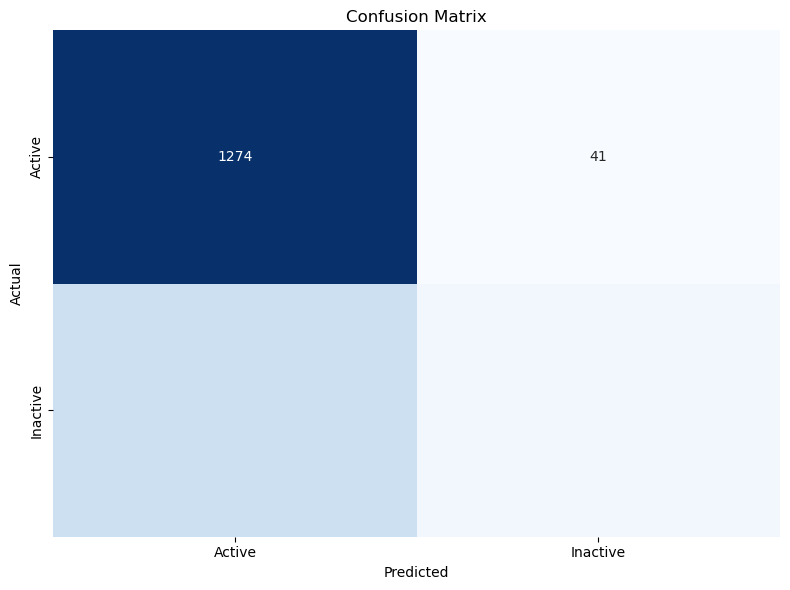

In [10]:
# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Create a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', cbar=False,
            xticklabels=['Active', 'Inactive'], yticklabels=['Active', 'Inactive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

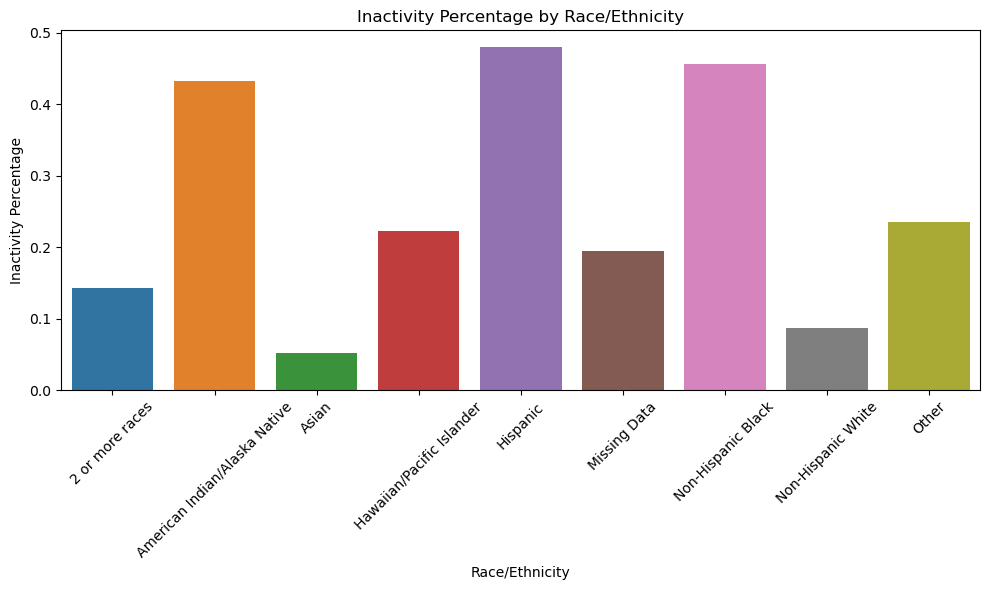

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

race_activity = activity_df.groupby('Race/Ethnicity')['Inactive'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=race_activity.index, y=race_activity.values)
plt.xlabel('Race/Ethnicity')
plt.ylabel('Inactivity Percentage')
plt.title('Inactivity Percentage by Race/Ethnicity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

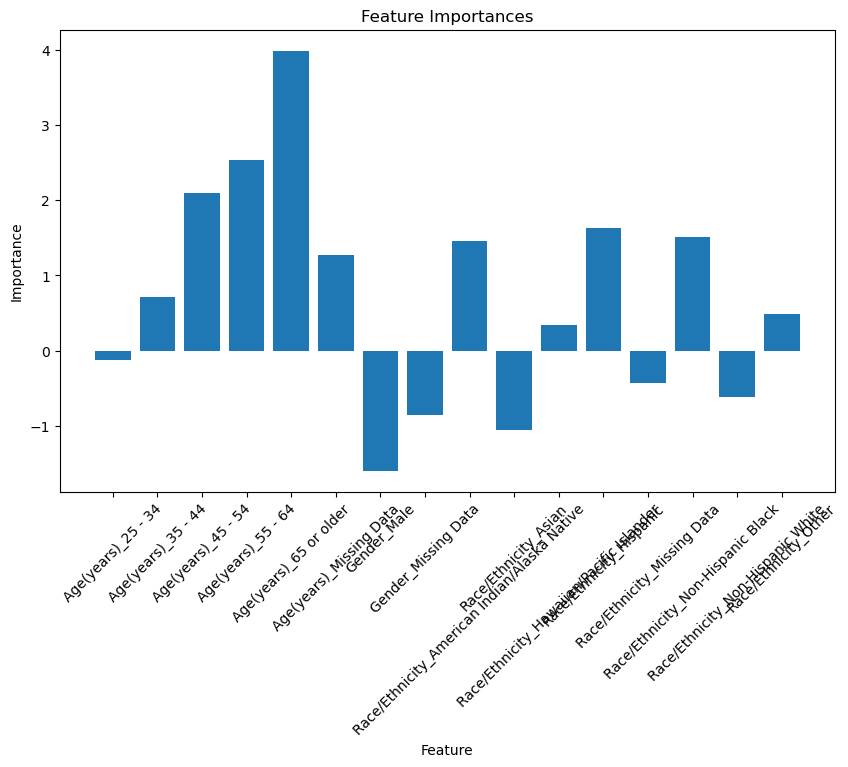

In [20]:
import matplotlib.pyplot as plt

feature_names = lr_model.feature_names_in_
feature_importances = lr_model.coef_[0]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=45)
plt.show()

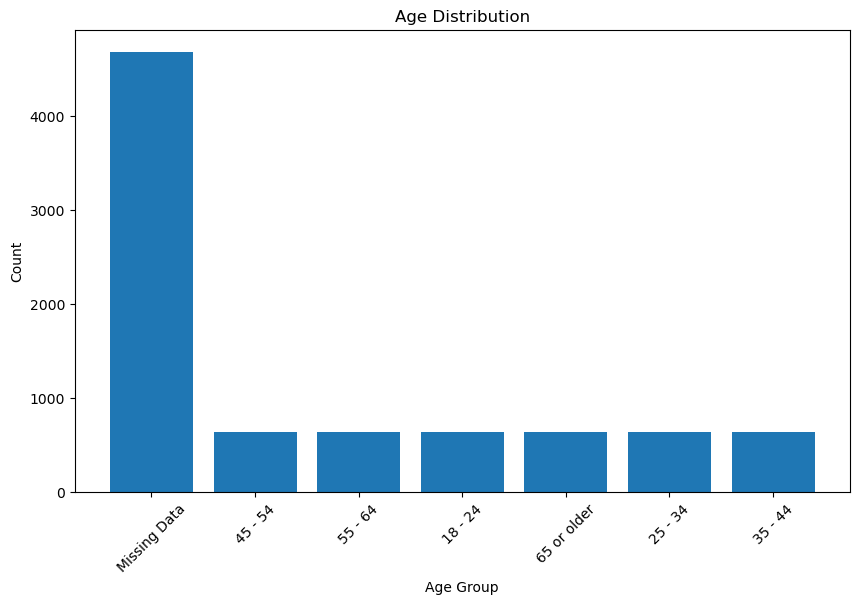

In [21]:
import matplotlib.pyplot as plt

age_counts = activity_df['Age(years)'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.xticks(rotation=45)
plt.show()

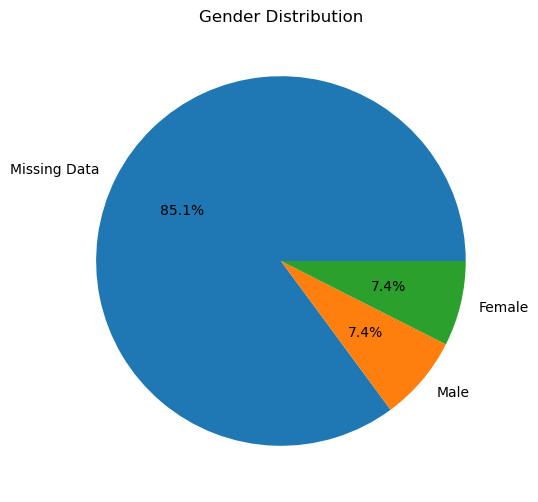

In [23]:
import matplotlib.pyplot as plt

gender_counts = activity_df['Gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()

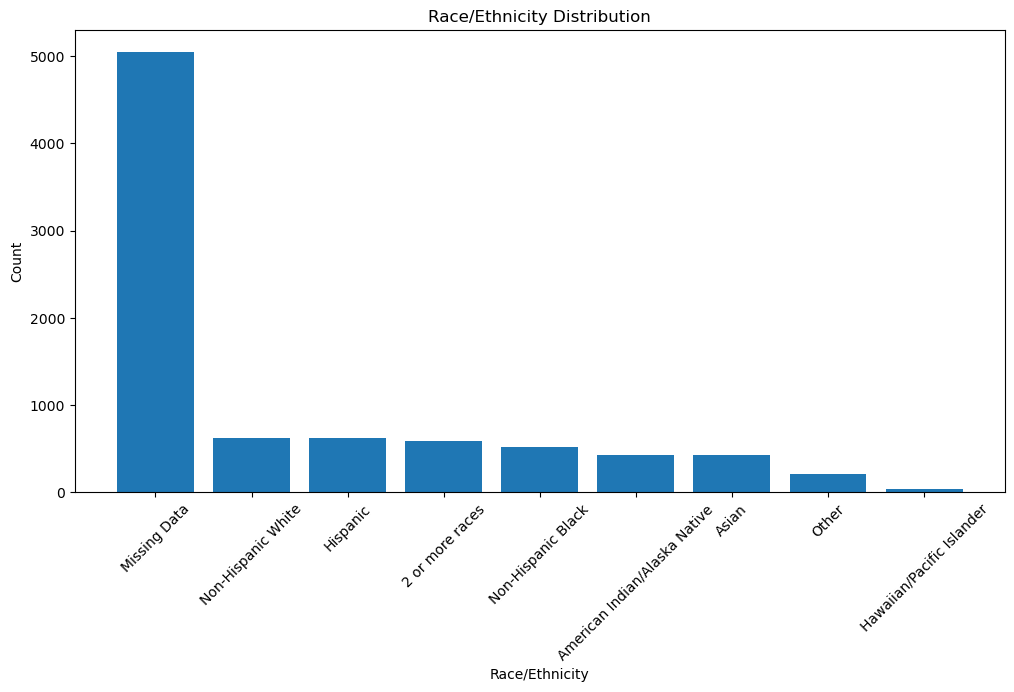

In [24]:
import matplotlib.pyplot as plt

race_counts = activity_df['Race/Ethnicity'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(race_counts.index, race_counts.values)
plt.xlabel('Race/Ethnicity')
plt.ylabel('Count')
plt.title('Race/Ethnicity Distribution')
plt.xticks(rotation=45)
plt.show()

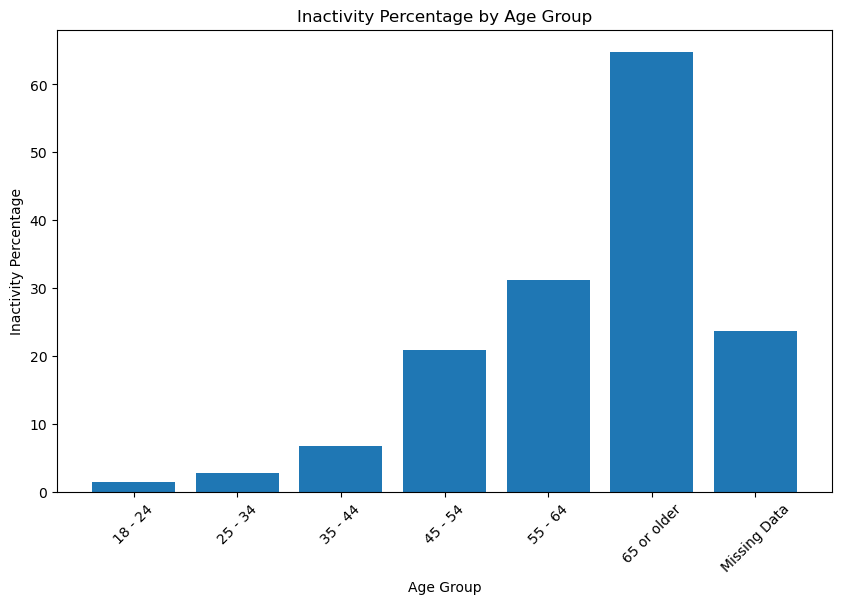

In [26]:
import matplotlib.pyplot as plt

age_inactivity = activity_df.groupby('Age(years)')['Inactive'].mean() * 100

plt.figure(figsize=(10, 6))
plt.bar(age_inactivity.index, age_inactivity.values)
plt.xlabel('Age Group')
plt.ylabel('Inactivity Percentage')
plt.title('Inactivity Percentage by Age Group')
plt.xticks(rotation=45)
plt.show()